<a href="https://colab.research.google.com/github/rgclapp007/gp211-class-notebooks/blob/main/Adjoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adjoints

In [2]:
import numpy as np
def forwardMatMult(A:np.ndarray,model:np.ndarray,data:np.ndarray):
    if A.shape[1]!=model.shape[0]:
        raise Exception("Model and array axis 1 don't agree in size")
        
    if A.shape[0]!=data.shape[0]:
        raise Exception("Data and array axis 2 don't agree in size")   
        
    for i2 in range(A.shape[0]):
        for i1 in range(A.shape[1]):
            data[i2]+=model[i1]*A[i2,i1]

            
def adjointMatMult(A:np.ndarray,model:np.ndarray,data:np.ndarray):
    if A.shape[1]!=model.shape[0]:
        raise Exception("Model and array axis 1 don't agree in size")
        
    if A.shape[0]!=data.shape[0]:
        raise Exception("Data and array axis 2 don't agree in size")   
        
    for i2 in range(A.shape[0]):
        for i1 in range(A.shape[1]):
        
            model[i1]+=data[i2]*A[i2,i1]

In [3]:
import numpy as np



def forwardLinInterp(x_data:np.ndarray,o_model:float, d_model:float, 
                     model:np.ndarray,data:np.ndarray):
    if x_data.shape[0]!=data.shape[0]:
        raise Exception("Data and locations must agree in size")

    for id in  range(data.shape[0]):
      fpos=(x_data[id]-o_model)/d_model
      ipos=int(fpos)
      fpos=fpos-ipos
      data[id]+=model[ipos]*(1.-fpos) + model[ipos+1]*fpos
    

            
def adjointLinInterp(x_data:np.ndarray,o_model:float, d_model:float, 
                     model:np.ndarray,data:np.ndarray):
    if x_data.shape[0]!=data.shape[0]:
        raise Exception("Data and locations must agree in size")

    for id in  range(data.shape[0]):
      fpos=(x_data[id]-o_model)/d_model
      ipos=int(fpos)
      fpos=fpos-ipos
      #data[id]+=model[ipos]*(1.-fpos) + model[ipos+1]*fpos
      model[ipos]+=data[id]*(1.-fpos)
      model[ipos+1]+=data[id]*fpos



# Our first class!

In [4]:
class myOperator:
  """ A generic operator class"""
  def __init__(self,domain,range):
    self._domain=domain
    self._range=range
  
  def forward(self,add:bool,model:np.ndarray,data:np.ndarray):
    raise Exception("Must override forward")

  def adjoint(self,add:bool,model:np.ndarray,data:np.ndarray):
    raise Exception("Must override adjoint")

  def checkDomainRange(self,mod:np.ndarray,dat:np.ndarray):
    return True
  #  if all mod.shape != self._domain.shape:
  #    raise Exception("mod and domain not the same")
  #  if all dat.shape != self._range.shape:
  #    raise Exception("dat and range not the same")
class Lin1D(myOperator):
  """Do linear interpolation 
  """

  def __init__(self,o_mod:float,d_mod:float,xpos:np.ndarray,model:np.ndarray,data:np.ndarray):
    super().__init(model,data)
    
    if xpos.shape[0]!=data.shape[0]:
      raise Exception("data and pos not the same size")
    
    self._xpos=xpos
    self._o=o_mod
    self._d=d_mod

    mx=self._o+self._d*(mod.shape[0]-1)
    for x in xpos:
      if x < self._o or x> mx:
        raise Exception("Data points outside model")

  def forward(self,add:bool,model:np.ndarray,data:np.ndarray):
      self.checkDomainRange(model,data)
      if not add:
        data.fill(0.)

      for id in  range(data.shape[0]):
        fpos=(x_data[id]-o_model)/d_model
        ipos=int(fpos)
        fpos=fpos-ipos
        data[id]+=model[ipos]*(1.-fpos) + model[ipos+1]*fpos
      

            
  def adjoint(self,add:bool,model:np.ndarray,data:np.ndarray):

      self.checkDomainRange(model,data)
      if not add:
        model.fill(0.)

      for id in  range(data.shape[0]):
        fpos=(x_data[id]-o_model)/d_model
        ipos=int(fpos)
        fpos=fpos-ipos
        #data[id]+=model[ipos]*(1.-fpos) + model[ipos+1]*fpos
        model[ipos]+=data[id]*(1.-fpos)
        model[ipos+1]+=data[id]*fpos


# Vector class


In [5]:
import numpy as np
class myVector:

  def __init__(self,*arg,**kw):
    """Initialize a vector class 
    
        Two different ways

        ar - Numpy array

        shape - The size of the array

        Optional:

          spaceOnly - Whether or not to allocate space for the array (default False)
    
    """

    self._spaceOnly=False
    if "spaceOnly" in kw:
      if not isinstance(kw["spaceOnly"],bool):
        raise Exception("spaceOnly should be a bool")
      self._spaceOnly=kw["spaceOnly"]
    if isinstance(arg[0],np.ndarray):
      self._ar=np.copy(arg[0])
      self._shape=list(arg[0].shape)
    elif isinstance(arg[0],list):
      self._ar=np.ndarray(arg[0])
      self._shape=arg[0]
    else:
      raise Exception(f"Arg must be a ndarray or list (size) type is {type(arg[0])}")
  
  def checkSame(self,vec:np.ndarray):
    """Check to make sure vectors match"""
    if list(self._ar.shape)!=list(vec._ar.shape):
      return False
    return True

  def validOp(self):
    """Check to make sure class is allocated"""
    if self._spaceOnly:
      raise Exception("Asked to use a vector when not allocated")
  
  def zero(self):
    "Zero vector"
    self.validOp()
    self._ar.fill(0)
  
  def scale(self,sc:float):
    """Scale a vector"""
    self.validOp()
    self._ar=self._ar*sc

  def scaleAdd(self,vec,sc1:float=1,sc2:float=1.):
    """ vec=self*sc1+vec*sc2"""
    self.validOp()
    vec.validOp()
    self.checkSame(vec)
    self._ar=self._ar*sc1+vec._ar*sc2

  def dot(self,vec):
    self.validOp()
    vec.validOp()
    self.checkSame(vec)
    return np.dot(self._ar.ravel(),vec._ar.ravel())

  def clone(self):
    """Make a copy of the vector"""
    if not self._spaceOnly: myVector(self._ar)
    return myVector(self._shape)
  
  def cloneSpace(self):
    """Make a copy of just the vector space"""
    return myVector(self._shape,spaceOnly=True)

  def rand(self):
    """Fill with a random number"""
    self._ar[:]=(2. * np.random.random(self._shape) - 1.)

  

In [6]:
class myOperator:
  """ A generic operator class"""
  def __init__(self,domain,range):
    self._domain=domain.cloneSpace()
    self._range=range.cloneSpace()
  
  def forward(self,add:bool,model:np.ndarray,data:np.ndarray):
    raise Exception("Must override forward")

  def adjoint(self,add:bool,model:np.ndarray,data:np.ndarray):
    raise Exception("Must override adjoint")

  def checkDomainRange(self,mod:np.ndarray,dat:np.ndarray):
    self._domain.checkSame(mod)
    self._range.checkSame(dat)


In [7]:
class Lin1D(myOperator):
  """Do linear interpolation 
  """

  def __init__(self,o_mod:float,d_mod:float,xpos:np.ndarray,model:myVector,data:myVector):
    super().__init__(model,data)
    
    if xpos.shape[0]!=data._shape[0]:
      raise Exception(f"xpos and data not the same size {xpos.shape[0]} {data._shape[0]}")
    
    self._xpos=xpos
    self._o=o_mod
    self._d=d_mod

    mx=self._o+self._d*(mod._shape[0]-1)
    for x in xpos:
      if x < self._o or x>= mx:
        raise Exception(f"Data points outside model val {x} min {self._o} max {mx}")

  def forward(self,add:bool,model:myVector,data:myVector):
      self.checkDomainRange(model,data)
      if not add:
        data.zero()

      for id in  range(data._shape[0]):
        fpos=(self._xpos[id]-self._o)/self._d
        ipos=int(fpos)
        fpos=fpos-ipos
        data._ar[id]+=model._ar[ipos]*(1.-fpos) + model._ar[ipos+1]*fpos
      

            
  def adjoint(self,add:bool,model:myVector,data:myVector):

      self.checkDomainRange(model,data)
      if not add:
        model.zero()

      for id in  range(data._shape[0]):
        fpos=(self._xpos[id]-self._o)/self._d
        ipos=int(fpos)
        fpos=fpos-ipos
        model._ar[ipos]+=data._ar[id]*(1.-fpos)
        model._ar[ipos+1]+=data._ar[id]*fpos

In [8]:
class MatMult(myOperator):
  """Do linear interpolation 
  """

  def __init__(self,mat:np.ndarray,model:myVector,data:myVector):
    super().__init__(model,data)
    self._mat=np.copy(mat)

    if model._shape[0]!=self._mat.shape[1]:
      raise Exception(f"matrix and model don't match {self.mat.shape[1]} {model._shape[0]}")
    if data._shape[0]!=self._mat.shape[0]:
      raise Exception(f"matrix and data don't match {self.mat.shape[0]} {data._shape[0]}")
       

  def forward(self,add:bool,model:myVector,data:myVector):
      self.checkDomainRange(model,data)
      if not add:
        data.zero()

      for id in  range(data._shape[0]):
        for im in range(model._shape[0]):
          data._ar[id]+=self._mat[id,im]*model._ar[im]

            
  def adjoint(self,add:bool,model:myVector,data:myVector):

      self.checkDomainRange(model,data)
      if not add:
        model.zero()

      for id in  range(data._shape[0]):
        for im in range(model._shape[0]):
          model._ar[im]+=self._mat[id,im]*data._ar[id]

In [9]:
x=np.array([1.4,2.2,3.1,4.4])
y=np.array([1.,2.,3.,4.])
m=np.ndarray((10))

dat=myVector(y)
mod=myVector(m)

op=Lin1D(0.,.5,x,mod,dat)
op.adjoint(False,mod,dat)


In [10]:
class chainOp(myOperator):
  # d = op1 op2 m

  def __init__(self,op1,op2):

    super().__init__( op2._domain,op1._range )

    if not op2._range.checkSame(op1._domain):
      raise Exception("Operators don't make ")
    
    self._mid=op2._range.clone()


  def forward(self,add,model,data):

    if not add:
      data.zero()

    op2.forward(False,model,self._mid)
    op1.forward(add,self._mid,data)

  def adjoint(self,add,model,data):

    if not add:
      model.zero()

      op1.adjoint(False,self._mid,data)
      op2.adjoint(add,model,self._mid)


In [18]:
class solver:
  def __init__(self,lop:myOperator,m0:myVector,d:myVector):
    self._lop=lop
    self._m0=m0.clone()
    self._rr=d.clone() # residual

    self._g=self._m0.clone() #gradient vec
    self._gg=self._rr.clone() #gradient mapped back into data space


  def updateModRes(self,mod:myVector,res:myVector):
    raise Exception("Need to override")

  def steepCalc(self,dir:myVector,rr:myVector):
    """Direction to seach"""
    self._lop.forward(False,dir,self._gg)
    top=rr.dot(self._gg)
    bot=self._gg.dot(self._gg)
    alpha=-top/(bot+1.e-10)
    return alpha
  
  def iterate(self,niter:int):
    self._rr.scale(-1.) # r=d
    self._lop.forward(True,self._m0,self._rr) #-d+Lm_0
    mod=self._m0.clone()
    mvec=[]
    rvec=[]
    mvec.append(np.copy(mod._ar))
    rvec.append(np.copy(self._rr._ar))
    for iter in range(niter):
      self.updateModRes(mod,self._rr)
      mvec.append(np.copy(mod._ar))
      rvec.append(np.copy(self._rr._ar))
    return mvec, rvec

class randomSolver(solver):

  def __init__(self,lop:myOperator,m0:myVector,d:myVector):
    super().__init__(lop,m0,d)


  def updateModRes(self,mod,rr):
    self._g.rand()
    alpha=self.steepCalc(self._g,rr)
    mod.scaleAdd(self._g,sc2=alpha)
    rr.scaleAdd(self._gg,sc2=alpha)


mod=np.array((2.,3.))
mat=np.array(((-3.,4.),(2.,12.)))
model=myVector(mod)
data=model.clone()
matOp=MatMult(mat,model,data)
matOp.forward(False,model,data)
print(data._ar)


[ 6. 40.]


In [81]:
model._ar[:]=(-199,179)

solve=randomSolver(matOp,model,data)
mvec,rvec=solve.iterate(100)

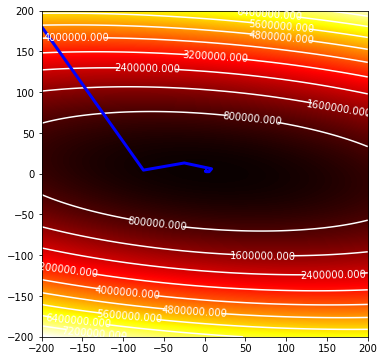

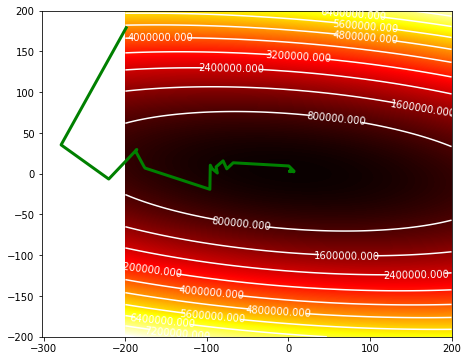

In [82]:
import matplotlib.pyplot as plt

def objPlot(mod,mn,mx,npts,col):

  npts=300
  obj=np.zeros((npts,npts))
  test=data.clone()
  ix=0
  for x in np.linspace(mn,mx,npts):
    iy=0
    for y in np.linspace(mn,mx,npts):
      model._ar[:]=(y,x)
      matOp.forward(False,model,test)
      test.scaleAdd(data,1,-1)
      obj[ix,iy]=test.dot(test)
      iy+=1
    ix+=1
  plt.figure(figsize=(8,6))
  contours = plt.contour(np.linspace(mn,mx,npts), np.linspace(mn,mx,npts), obj, 10, colors='white')
  plt.clabel(contours, inline=1, fontsize=10)
  plt.imshow(obj[::-1,:],extent=(mn,mx,mn,mx),cmap=plt.cm.hot)
  x=[[v[0]] for v in mod ]
  y=[[v[1]] for v in mod ] 
  plt.plot(x, y, color=col, linewidth=3)
objPlot(mvec,-200,200,300,"blue")
model.zero()
model._ar[:]=(-199,179)
solve=randomSolver(matOp,model,data)

mvec,rvec=solve.iterate(100)
objPlot(mvec,-200,200,300,"green")


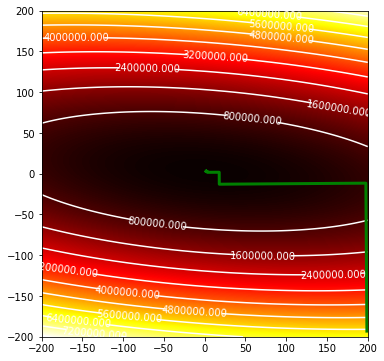

In [79]:
class steepSolver(solver):

  def __init__(self,lop:myOperator,m0:myVector,d:myVector):
    super().__init__(lop,m0,d)

  def updateModRes(self,mod,rr):
    self._lop.adjoint(False,self._g,rr)
    alpha=self.steepCalc(self._g,rr)
    mod.scaleAdd(self._g,sc2=alpha)
    rr.scaleAdd(self._gg,sc2=alpha)

model.zero()
model._ar[:]=(199,-193)
solve=steepSolver(matOp,model,data)

mvec,rvec=solve.iterate(50)
objPlot(mvec,-200,200,300,"green")

SC AFTER [ 752.78166832 2302.43049234] [-466.21833168  152.43049234]
SC AFTER [ 466.21833168 -152.43049234] [0.00000000e+00 2.84217094e-14]
[ 139. -199.]
[143.00777158  -7.79875424]
[2. 3.]


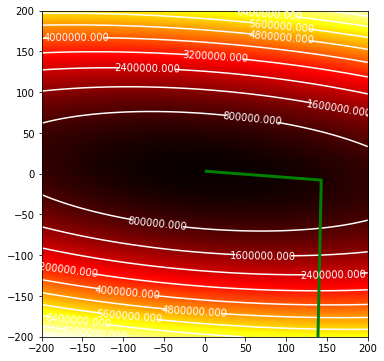

In [78]:
class cgSolver(solver):

  def __init__(self,lop:myOperator,m0:myVector,d:myVector):
    super().__init__(lop,m0,d)
    self._s=None
    self._ss=None




  def updateModRes(self,mod,rr):
    
    self._lop.adjoint(False,self._g,rr)

    if self._s is None:
      #Do steepest descent
      self._s=mod.clone()
      self._ss=rr.clone()
      self._s.zero()
      self._ss.zero()
      alpha=self.steepCalc(self._g,rr)
      beta=0.
    else:
      #DO CGSTEP
      self._lop.forward(False,self._g,self._gg)
      g_g=self._gg.dot(self._gg)
      g_s=self._gg.dot(self._ss)
      s_s=self._ss.dot(self._ss)
      if g_g ==0 or s_s==0:
        raise Exception("Solver is stuck")
      determ=g_g*s_s*max(1.-(g_s/g_g)*(g_s/s_s),1.e-12)
      g_r=-self._gg.dot(rr)
      s_r=-rr.dot(self._ss)
      alpha = ( s_s*g_r - g_s*s_r ) / determ 
      beta = (-g_s*g_r + g_g*s_r ) / determ

      
    self._s.scaleAdd(self._g,sc2=alpha,sc1=beta)
    self._ss.scaleAdd(self._gg,sc2=alpha,sc1=beta)
    mod.scaleAdd(self._s) #mod=mod+s
    rr.scaleAdd(self._ss) #RES=res+ss

model.zero()
model._ar[:]=(139,-199)
solve=cgSolver(matOp,model,data)
mvec,rvec=solve.iterate(2)

objPlot(mvec,-200,200,300,"green")